In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, os, time
from google.colab import drive


# load data

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/data_upload_v3.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04316-study1-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04347-study7-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04382-study1-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04437-study1-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04466-study1-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04689-study1-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04733-study7-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04773-study1-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04773-study4-view1_frontal.jpg  
  inflating: dataset/data_upload_v3/test/non/Atelectasis/patient04826-study1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_epochs = 30

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/dataset/data_upload_v3'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
dataset_sizes

{'train': 2084, 'test': 3100}

## Data Augmentation

In [6]:
def show_images(images, label):
  plt.figure(figsize=(20, 20))
  for i in range(1, 8):
      plt.subplot(1, 8, i)
      plt.imshow(images[i - 1])
      plt.xticks([])
      plt.yticks([])
      plt.title(label)

In [7]:
from PIL import Image

covid_path = os.path.join(data_dir, 'train/covid')
non_path = os.path.join(data_dir, 'train/non')

covid_images = [Image.open(os.path.join(covid_path, name)) for name in os.listdir(covid_path)]
non_images = [Image.open(os.path.join(non_path, name)) for name in os.listdir(non_path)]

In [8]:
transform_resize = transforms.Resize((227 , 227))
covid_images = [transform_resize(image) for image in covid_images]
non_images = [transform_resize(image) for image in non_images]

In [9]:
print('covid images train numner:', len(covid_images))
print('non_covid images train numner:', len(non_images))

covid images train numner: 84
non_covid images train numner: 2000


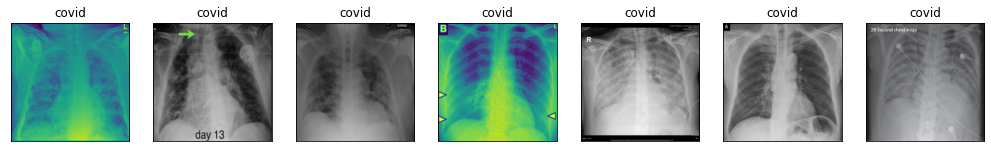

In [10]:
show_images(covid_images, 'covid')

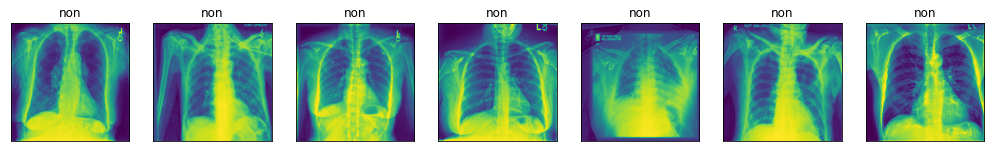

In [11]:
show_images(non_images, 'non')

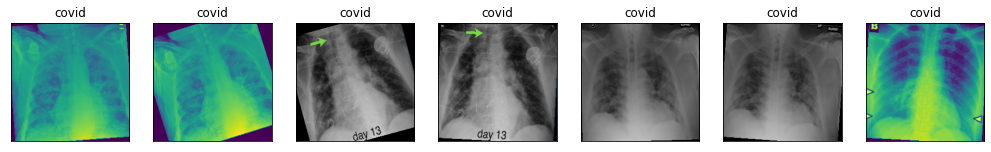

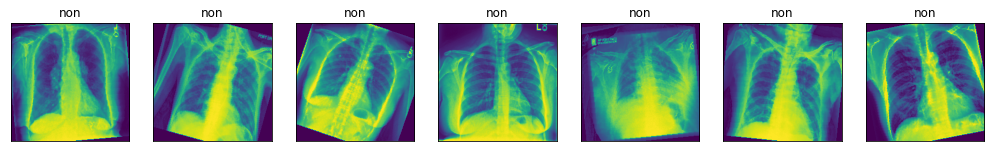

In [13]:
transform_rotate = transforms.RandomRotation((-20 , 20))
rotate_covid = [transform_rotate(image) for image in covid_images for _ in range(2)]
rotate_non = [transform_rotate(image) for image in non_images]
show_images(rotate_covid, 'covid')
show_images(rotate_non, 'non')

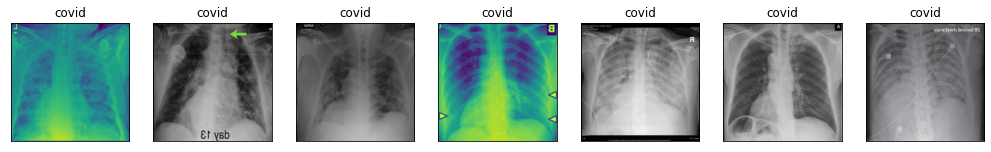

In [14]:
transform_horizontal_flip = transforms.RandomHorizontalFlip(p =1)
horizontal_flip_covid = [transform_horizontal_flip(image) for image in covid_images]
show_images(horizontal_flip_covid, 'covid')

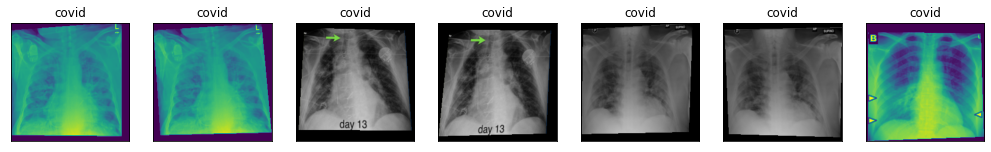

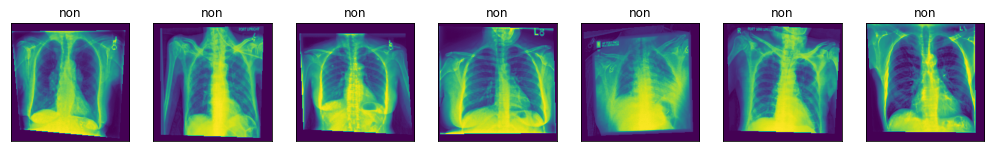

In [15]:
transform_perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1)
perspective_covid = [transform_perspective(image) for image in covid_images for _ in range(2)]
perspective_non = [transform_perspective(image) for image in non_images]
show_images(perspective_covid, 'covid')
show_images(perspective_non, 'non')

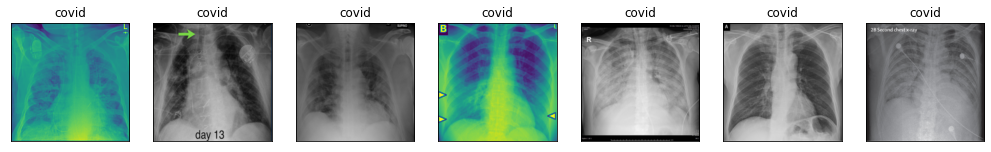

In [16]:
transform_adjust_shapness = transforms.RandomAdjustSharpness(sharpness_factor=2)
adjust_shapness_covid = [transform_adjust_shapness(image) for image in covid_images]
show_images(adjust_shapness_covid, 'covid')

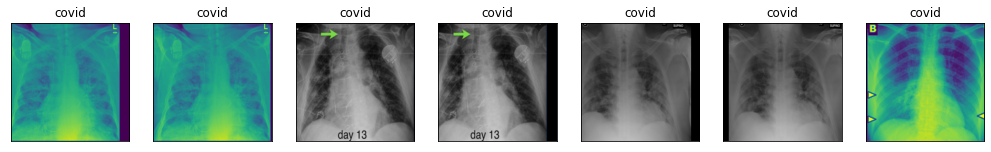

In [17]:
transform_horizontal_affine = transforms.RandomAffine(degrees=0, translate =(0.1, 0))
horizontal_affine_covid = [transform_horizontal_affine(image) for image in covid_images for _ in range(2)]
show_images(horizontal_affine_covid, 'covid')

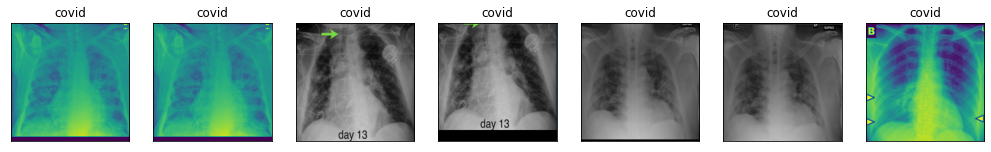

In [18]:
transform_vertical_affine = transforms.RandomAffine(degrees=0, translate =(0, 0.1))
vertical_affine_covid = [transform_vertical_affine(image) for image in covid_images for _ in range(2)]
show_images(vertical_affine_covid, 'covid')

In [20]:
import random

covid_new = covid_images + rotate_covid + horizontal_flip_covid + perspective_covid \
+ perspective_covid + adjust_shapness_covid + horizontal_affine_covid + vertical_affine_covid

non_new = non_images + rotate_non + perspective_non

random.shuffle(covid_new)
random.shuffle(non_new)

# build and train model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 20):
    since = time.time()
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                #print(cur_batch_ind,"batch inputs shape:", inputs.shape)
                #print(cur_batch_ind,"batch label shape:", labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [ ]:
model_conv = torchvision.models.squeezenet1_0(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# change classifier number of classes to from 1000 to 2
model_conv.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1))

model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs=num_epochs)
    model_conv.eval()
    torch.save(model_conv, './squeeznet.pt')


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Epoch 1/30
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Streaming output truncated to the last 5000 lines.
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
24-th epoch, 22-th batch (size=64), train acc= 0.984 


preds: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
label: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
24-th epoch, 23-th batch (size=64), train acc= 1.000 


preds: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1,

# calculate metrics

In [ ]:
def drawProbabilitiesHistogram(positive_covid_probabilities, negative_covid_probabilities):
  bins = np.linspace(0, 1, 20)
  plt.subplot(2, 1, 1)
  plt.hist(positive_covid_probabilities, bins, color= 'red', histtype = 'bar', label='histogram of covid 19 probabilities')
  plt.legend(loc='upper center')
  plt.subplot(2, 1, 2)
  plt.hist(negative_covid_probabilities, bins, color= 'blue', label='histogram of non-covid probabilities')
  plt.legend(loc='upper center')


In [ ]:
final_model_path =  '/content/squeeznet.pt'
final_model= torch.load(final_model_path, map_location='cpu') 
final_model.eval()
class_names = ['covid','non-covid'] 

In [ ]:
def evaluate_model(testimages , threshold):
  positive_covid_probabilities = list() 
  negative_covid_probabilities = list()
  total_pred = list()
  true_labels = list()

  for  inputs, labels in testimages:
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = final_model(cur_img)
    cur_prob = torch.nn.Softmax()(out)

    if float(cur_prob[0][0])> threshold:
      out = 0 
      total_pred.append(out)
      true_labels.append(labels)
    else:
      out = 1 
      total_pred.append(out)
      true_labels.append(labels)

  for  inputs, labels in testimages:
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = final_model(cur_img)
    cur_prob = torch.nn.Softmax()(out)
    if labels == 0 :
        positive_covid_probabilities.append(cur_prob.data.numpy()[0,0])
    if labels == 1 :
        negative_covid_probabilities.append(cur_prob.data.numpy()[0,0])
  x = 0
  for i in range(3100):
    if true_labels[i] == 0 and total_pred[i] == 1:
      x += 1
  y = 0
  for i in range(3100):
    if true_labels[i] == 1 and total_pred[i] == 0:
      y += 1
  sensivity = (100 - x) / 100
  specificity =  (3000 - y) / 3000
  print('sensitivity is :', sensivity)
  print('specificity is :', specificity)
  return positive_covid_probabilities, negative_covid_probabilities


# different thhresholds

## threshold 0.05 

In [ ]:
positive_covid_probabilities, negative_covid_probabilities = evaluate_model(image_datasets['test'] , 0.05)

<ipython-input-23-ee6e072e817a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)
<ipython-input-23-ee6e072e817a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)


sensitivity is : 0.92
specificity is : 0.964


## threshold 0.1

In [ ]:
positive_covid_probabilities, negative_covid_probabilities = evaluate_model(image_datasets['test'] , 0.1)

<ipython-input-23-ee6e072e817a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)
<ipython-input-23-ee6e072e817a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)


sensitivity is : 0.91
specificity is : 0.9823333333333333


## threshold 0.2

In [ ]:
positive_covid_probabilities, negative_covid_probabilities = evaluate_model(image_datasets['test'] , 0.2)

<ipython-input-23-ee6e072e817a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)
<ipython-input-23-ee6e072e817a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)


sensitivity is : 0.87
specificity is : 0.9933333333333333


## threshold 0.3


In [ ]:
positive_covid_probabilities, negative_covid_probabilities = evaluate_model(image_datasets['test'] , 0.3)

<ipython-input-23-ee6e072e817a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)
<ipython-input-23-ee6e072e817a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)


sensitivity is : 0.74
specificity is : 0.9963333333333333


## threshold 0.4

In [ ]:
positive_covid_probabilities, negative_covid_probabilities = evaluate_model(image_datasets['test'] , 0.4)

<ipython-input-23-ee6e072e817a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)
<ipython-input-23-ee6e072e817a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)


sensitivity is : 0.65
specificity is : 0.997


## threshold 0.5

In [ ]:
positive_covid_probabilities, negative_covid_probabilities = evaluate_model(image_datasets['test'] , 0.5)

<ipython-input-23-ee6e072e817a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)
<ipython-input-23-ee6e072e817a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cur_prob = torch.nn.Softmax()(out)


sensitivity is : 0.6
specificity is : 0.9976666666666667


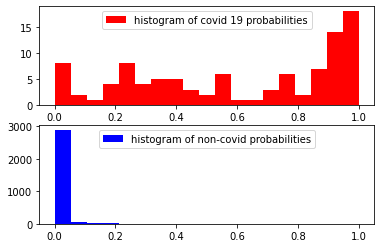

In [ ]:
drawProbabilitiesHistogram(positive_covid_probabilities , negative_covid_probabilities)